In [2]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
# Load data
from os import listdir
for file in filter(lambda x: x.split('.')[-1] == 'pickle', listdir('Pickles')):
    var = file.split('.')[0]
    exec('{} = pickle.load(open("Pickles/{}", "rb"))'.format(var, file))
    print('Got {}'.format(var))

Got df
Got features_test
Got features_train
Got initial_dataset
Got labels_test
Got labels_train
Got tfidf
Got X_test
Got X_train
Got y_test
Got y_train


In [5]:
features_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.12950732],
       ...,
       [0.0731778 , 0.        , 0.15323633, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.14704836, ..., 0.        , 0.        ,
        0.        ]])

In [4]:
# Let's check the dimension of our feature vectors
print(features_train.shape)
print(features_test.shape)

(1571, 300)
(278, 300)


In [5]:
# n_estimators
n_estimators = [200, 800]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [10, 40]
max_depth.append(None)

# min_samples_split
min_samples_split = [10, 30, 50]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# learning rate
learning_rate = [.1, .5]

# subsample
subsample = [.5, 1.]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               'subsample': subsample}

pprint(random_grid)

{'learning_rate': [0.1, 0.5],
 'max_depth': [10, 40, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [10, 30, 50],
 'n_estimators': [200, 800],
 'subsample': [0.5, 1.0]}


In [6]:
# First create the base model to tune
gbc = GradientBoostingClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=random_grid,
    n_iter=50,
    scoring='accuracy',
    cv=3, 
    verbose=1, 
    random_state=8,
    n_jobs=-1                         # Multithread job
)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 81.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 378.4min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [7]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40, 'learning_rate': 0.1}

The mean accuracy of a model with these hyperparameters is:
0.6136218968809676


In [8]:
# Create the parameter grid based on the results of random search 
max_depth = [5, 10, 15]
max_features = ['sqrt']
min_samples_leaf = [2]
min_samples_split = [50, 100]
n_estimators = [800]
learning_rate = [.1, .5]
subsample = [1.]

param_grid = {
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'subsample': subsample

}

# Create a base model
gbc = GradientBoostingClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(
    estimator=gbc, 
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv_sets,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 63.8min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_sa...
                                                  random_state=8, subsample=1.0,
                                                  tol=0.0001,
                                                  validation_f

In [9]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 50, 'n_estimators': 800, 'subsample': 1.0}

The mean accuracy of a model with these hyperparameters is:
0.4206807964033398


In [10]:
best_gbc = grid_search.best_estimator_
best_gbc

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=50,
                           min_weight_fraction_leaf=0.0, n_estimators=800,
                           n_iter_no_change=None, presort='auto',
                           random_state=8, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [11]:
# Fit our model with training data
best_gbc.fit(features_train, labels_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=50,
                           min_weight_fraction_leaf=0.0, n_estimators=800,
                           n_iter_no_change=None, presort='auto',
                           random_state=8, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [1]:
# Predict test feature
gbc_pred = best_gbc.predict(features_test)
gbc_pred

NameError: name 'best_gbc' is not defined

In [13]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_gbc.predict(features_train)))

# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, gbc_pred))

# Classification report
print("Classification report")
print(classification_report(labels_test,gbc_pred))

The training accuracy is: 
1.0
The test accuracy is: 
0.7158273381294964
Classification report
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        42
           1       0.73      0.81      0.77        59
           2       0.00      0.00      0.00         1
           3       0.29      0.50      0.36         4
           4       0.62      0.62      0.62        26
           5       0.50      0.33      0.40         3
           6       0.00      0.00      0.00         0
           7       0.55      0.75      0.63         8
           8       0.58      0.50      0.54        14
           9       0.88      0.78      0.82         9
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.33      0.29      0.31         7
          13       0.75      0.50      0.60         6
          14       0.89      0.47      0.62        17
          15       0.30      0.50      0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


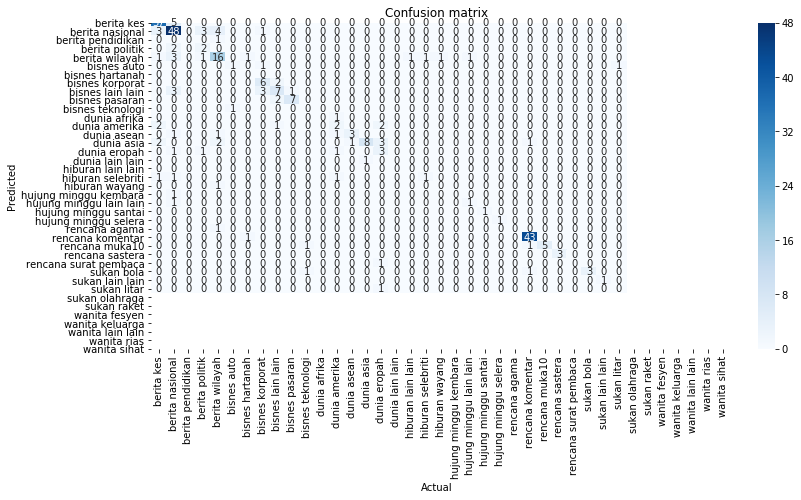

In [14]:
aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, gbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [15]:
# Let's see if the hyperparameter tuning process has returned a better model
base_model = GradientBoostingClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.6546762589928058

In [16]:
best_gbc.fit(features_train, labels_train)
accuracy_score(labels_test, best_gbc.predict(features_test))

0.7158273381294964

In [17]:
d = {
     'Model': 'Gradient Boosting',
     'Training Set Accuracy': accuracy_score(labels_train, best_gbc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, gbc_pred)
}

df_models_gbc = pd.DataFrame(d, index=[0])
df_models_gbc

,Model,Training Set Accuracy,Test Set Accuracy
0,Gradient Boosting,1.0,0.715827


In [18]:
# Save model and dataset
from os import mkdir
from os.path import exists
if not exists('Models'): mkdir('Models')

with open('Models/best_gbc.pickle', 'wb') as output:
    pickle.dump(best_gbc, output)
    
with open('Models/df_models_gbc.pickle', 'wb') as output:
    pickle.dump(df_models_gbc, output)

In [19]:
features_test

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.20291414]])